In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# Loading data

In [2]:
input_path = '../input/data_50k.tsv'
data = pd.read_csv(input_path, sep = '\t', header = None, \
    names = ['user_id', 'conversion_id', 'repeat', 'event_timestamp', 'run_timestamp', 'advertisements'],\
    usecols = ['user_id', 'conversion_id', 'event_timestamp', 'advertisements'])
print data.shape
data.head(3)

(50000, 4)


,user_id,conversion_id,event_timestamp,advertisements
0,000000b7-6230-4900-a27f-c92e0ba6fc4c,NaN,2016-09-12 17:42:58.0,"[[{""vendorId"": ""1480887"", ""adSize"": ""unknown"",..."
1,000001b9-0cea-4ebf-80a8-efe22c902a64,NaN,2016-10-10 15:44:53.0,"[[{""pageUrlhost"": ""www.atkins.com"", ""domainCoo..."
2,00000621-8230-4551-82ba-45f08de06094,NaN,2016-08-24 05:27:50.0,"[[{""vendorId"": ""1480887"", ""placementId"": ""1316..."


In [3]:
# check the format for the input data is consistent
data.tail(3)

,user_id,conversion_id,event_timestamp,advertisements
49997,075fb5ce-638e-4569-86e3-ae3503fff94d,NaN,2016-12-04 01:00:52.0,"[[{""pageUrlhost"": ""www.atkins.com"", ""domainCoo..."
49998,075fbbdd-f7fc-43ac-87c3-bf5c277eb811,NaN,2016-08-20 23:07:00.0,"[[{""vendorId"": ""1451748"", ""placementId"": ""1289..."
49999,075fda98-99af-4a31-8c3f-11758c7fbdaf,NaN,2016-09-25 20:57:55.0,"[[{""vendorId"": ""1480887"", ""placementId"": ""1333..."


# Data Exploring

In [4]:
# There are duplicate users
len(set(data['user_id']))

49967

In [5]:
# the basic conversion rate => unblance (AUC, StratifiedKFold, SMOTEENN)
1- 1.0 * data['conversion_id'].isnull().sum() / data.shape[0]

0.00770000000000004

### Extract features from advertisements

In [6]:
# the information in advertisements
import json
ad_keys = set()
for index, lst_ads in data['advertisements'].iteritems():
    lst_ads = json.loads(lst_ads)
    for ad in lst_ads:
        for key in ad[0].keys():
            ad_keys.add(key)
ad_keys

{u'action',
 u'adPosition',
 u'adServerId',
 u'adSize',
 u'adgroupId',
 u'advertiserProduct',
 u'campaignId',
 u'channel',
 u'clCookieId',
 u'creativeId',
 u'deviceType',
 u'domainCookieId',
 u'impressionId',
 u'inferredDma',
 u'keyword',
 u'keywordId',
 u'matchType',
 u'organicSource',
 u'pageUrlhost',
 u'placementId',
 u'publisherId',
 u'rawChannel',
 u'refrUrlhost',
 u'strategy',
 u'vendorId'}

In [7]:
for key in ad_keys:
    items = set()
    for index, lst_ads in data['advertisements'].iteritems():
        lst_ads = json.loads(lst_ads)
        for ad in lst_ads:
            items.add(ad[0].get(key))
    print key, len(items)
    if len(items) < 50:
        print ','.join([str(e) for e in items])

vendorId 9
facebook,google,bing,1480887,atkins_ir,None,1451748,atkins_dcm,silverpop
placementId 187
campaignId 35
5off,ECOM,201321936,188853576,202857576,204494976,204495096,603951798,186903936,US_EN_ECRM-L2,US_EN_ECRM-L1,9480859,201306696,202858776,9718623,Lifestyle,6046074859999,164360616,ecom,None,131111976,603951789,133156491,125068776,202857456,121216_US_EN_PROM_FREE5PK,6046076740199,ECRM,603951801,132068509,120716_US_EN_ECRM-A20-P1,10260197,120716_US_EN_ECRM-A20-P2,6046075758599,120716_US_EN_ECRM-A40
impressionId 23940
advertiserProduct 3
atkins,unknown,None
keywordId 149
creativeId 280
domainCookieId 7022
adPosition 11
none,1t5,1t2,1t3,1o1,1t1,1t4,1s1,None,1s5,2s3
strategy 3
unknown,None,unknown-leadgen
deviceType 6
Tablet,Mobile,Unknown,Computer,None,Game console
matchType 3
exact,broad,None
channel 10
search,affiliate-inferred,email,social-inferred,social,affiliate,sem,None,display,email-inferred
pageUrlhost 713
adSize 4
unknown,None,silverpop,unknown-leadgen
refrUrlhost 2138


In [8]:
# initial select feature based on
# 1) channel level attribution: (adPosition, adgroupId)
# 2) feature diversity
# 3) feature correlation: channel, rawChannel exactly correlated
ad_ukeys = ['vendorId', 'deviceType', 'matchType', 'channel', 'action']

ad_info = dict()
for key in ad_ukeys:
    items = set()
    for index, lst_ads in data['advertisements'].iteritems():
        lst_ads = json.loads(lst_ads)
        for ad in lst_ads:
            items.add(ad[0].get(key))
    ad_info[key] = items

In [9]:
# dummy for the classes in each category
add_feature = []
for key, value in ad_info.items():
    add_feature.extend([key+'_'+str(e) for e in value])
    
for key in add_feature:
    data[key] = 0

In [10]:
# feature variables: the number of advertisements involved
for index, lst_ads in data['advertisements'].iteritems():
    lst_ads = json.loads(lst_ads)
    for ad in lst_ads:
        add_feature = []
        for key in ad_ukeys:
            add_feature.append(key+'_'+str(ad[0].get(key)))
        data.ix[index, add_feature] += len(ad[1])

### Extracts features from event_timestamp

In [11]:
from datetime import datetime

def datetimeConverter(value, format):
    try:
        return datetime.strptime(value, format)
    except (TypeError, ValueError) as e:
        print e
        return pd.NaT
    
data['event_timestamp'] = data['event_timestamp'].map(lambda x: datetimeConverter(x, '%Y-%m-%d %H:%M:%S.%f'))

In [12]:
# event time range (2016-7-27 ~ 2017-01-12)
data['event_timestamp'].describe()

count                   50000
unique                  49785
top       2016-10-03 15:35:02
freq                        6
first     2016-07-27 22:19:50
last      2017-01-12 02:19:08
Name: event_timestamp, dtype: object

In [13]:
# create features: timespan, year, hours of a day, month, day of week
min_date = min(data['event_timestamp'])
data['event_days'] = data['event_timestamp'].map(lambda x: x-min_date).map(lambda x: x.days)
data['event_yr'] = data['event_timestamp'].map(lambda x: x.year-2016)
data['event_hr'] = data['event_timestamp'].map(lambda x: x.hour + x.minute/60.0)
data['event_month'] = data['event_timestamp'].map(lambda x: x.month)
data['event_weekday'] = data['event_timestamp'].map(lambda x: x.weekday())

In [14]:
### Transformation of conversion_id as 0/1
data.loc[data['conversion_id'].notnull(), 'conversion_id'] = 1
data['conversion_id'] = data['conversion_id'].fillna(0)

In [15]:
data = data.drop(['user_id', 'event_timestamp', 'advertisements'], axis = 1)

In [16]:
data.describe()

,conversion_id,action_imp,action_None,action_click,vendorId_facebook,vendorId_google,vendorId_bing,vendorId_1480887,vendorId_atkins_ir,vendorId_None,...,channel_affiliate,channel_sem,channel_None,channel_display,channel_email-inferred,event_days,event_yr,event_hr,event_month,event_weekday
count,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,...,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.00000,50000.00000,50000.000000,50000.000000,50000.000000
mean,0.007700,0.907980,0.006360,0.158080,0.003380,0.018040,0.001660,0.659040,0.000020,0.137500,...,0.001840,0.018620,0.006360,0.897060,0.000060,61.90856,0.00144,12.183149,9.391800,2.932120
std,0.087412,0.684574,0.079496,0.516891,0.059065,0.144758,0.045796,0.718969,0.004472,0.482243,...,0.044684,0.148168,0.079496,0.690936,0.007746,33.17340,0.03792,7.086649,1.144971,1.989701
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,1.000000,0.000000
25%,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,1.000000,0.000000,42.00000,0.00000,5.416667,9.000000,1.000000
50%,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,1.000000,0.000000,59.00000,0.00000,13.316667,9.000000,3.000000
75%,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,1.000000,0.000000,83.00000,0.00000,18.183333,10.000000,5.000000
max,1.000000,58.000000,1.000000,25.000000,2.000000,5.000000,3.000000,28.000000,1.000000,23.000000,...,2.000000,5.000000,1.000000,58.000000,1.000000,168.00000,1.00000,23.983333,12.000000,6.000000


/Users/didle/OtherSoftwares/anaconda2/lib/python2.7/site-packages/matplotlib/figure.py:397: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


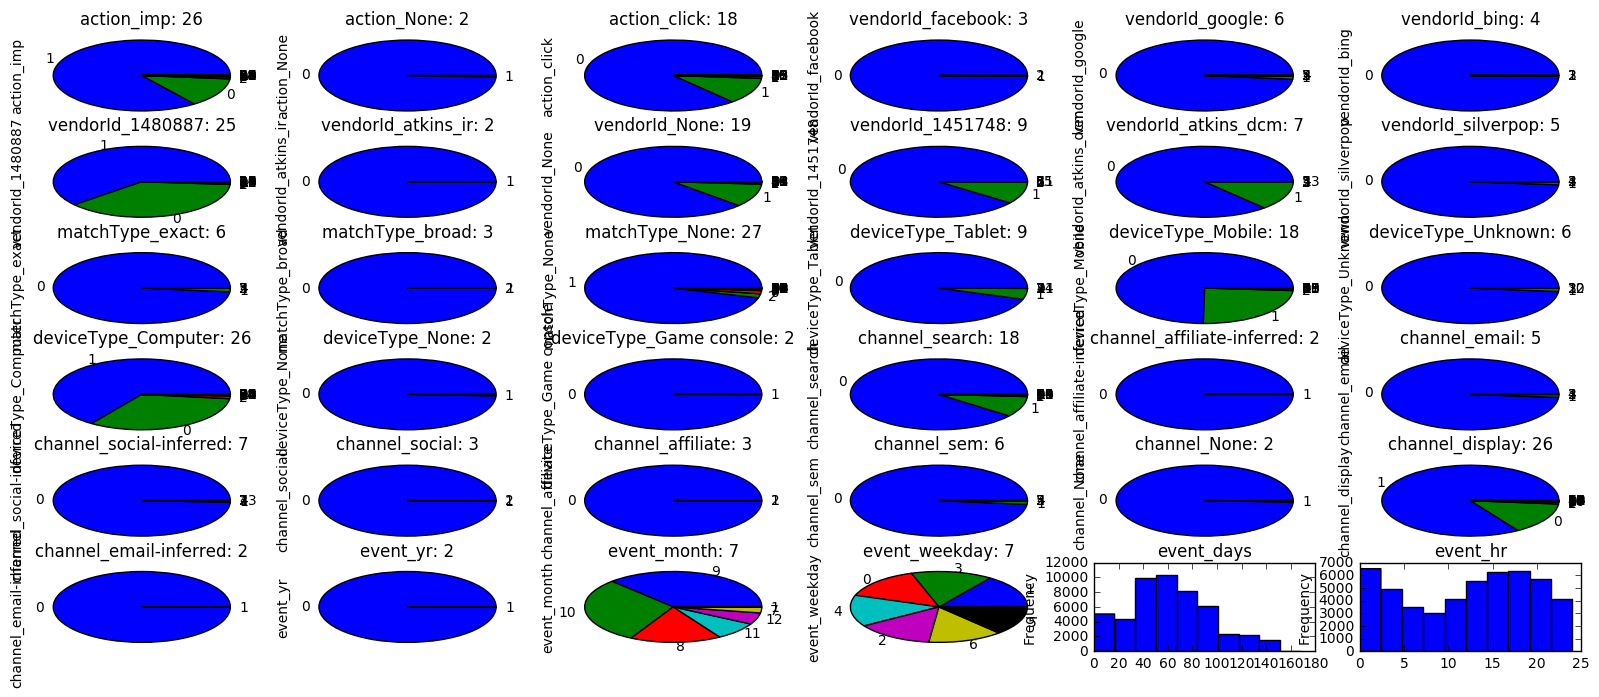

In [17]:
# Explore the distribution of each feature
# Pie plot usually is not for contineous variables, but here it looks fine
fig = plt.figure(figsize=[20,8])
nrow = 6
ncol = 6

i = 0
for key in list(data.columns.values):
    if key not in ['conversion_id','event_days', 'event_hr']:
        fig.add_subplot(nrow, ncol, i+1)
        i = i+1
        data[key].value_counts().plot.pie(title=key+': '+str(len(set(data[key]))), use_index = False)
fig.add_subplot(nrow, ncol, i+1)
data['event_days'].plot.hist(title = 'event_days', use_index = False)
fig.add_subplot(nrow, ncol, i+2)
data['event_hr'].plot.hist(title = 'event_hr', use_index = False)
fig.show()

In [18]:
# the correlation among features
cor_matrix = data.corr().stack()
cor_matrix = cor_matrix.reset_index()
cor_matrix.columns = ['level_0', 'level_1', 'corr']
cor_matrix.loc[(cor_matrix['level_0'] < cor_matrix['level_1']) & (abs(cor_matrix['corr']) >= 0.9), :]

,level_0,level_1,corr
20,conversion_id,deviceType_None,0.902508
67,action_imp,channel_display,0.985665
74,action_None,conversion_id,0.908218
94,action_None,deviceType_None,0.993729
103,action_None,channel_None,1.000000
120,action_click,vendorId_None,0.927073
486,matchType_exact,vendorId_google,0.918137
823,channel_search,vendorId_None,0.941679
900,channel_email,vendorId_silverpop,1.000000
966,channel_social,vendorId_facebook,1.000000


In [19]:
# remove features from exactly correlated feature pairs
data = data.drop(['action_None', 'vendorId_facebook', 'vendorId_silverpop'], axis = 1)
data.head(3)
#action_None	channel_None
#vendorId_facebook	channel_social
#vendorId_silverpop	channel_email

,conversion_id,action_imp,action_click,vendorId_google,vendorId_bing,vendorId_1480887,vendorId_atkins_ir,vendorId_None,vendorId_1451748,vendorId_atkins_dcm,...,channel_affiliate,channel_sem,channel_None,channel_display,channel_email-inferred,event_days,event_yr,event_hr,event_month,event_weekday
0,0,1,0,0,0,1,0,0,0,0,...,0,0,0,1,0,46,0,17.700000,9,0
1,0,0,1,0,0,0,0,1,0,0,...,0,0,0,0,0,74,0,15.733333,10,0
2,0,1,0,0,0,1,0,0,0,0,...,0,0,0,1,0,27,0,5.450000,8,2


In [20]:
# the correlation between features and target
cor_matrix.loc[cor_matrix['level_0'] == 'conversion_id', :].sort_values('corr', ascending=False)

,level_0,level_1,corr
0,conversion_id,conversion_id,1.000000
2,conversion_id,action_None,0.908218
29,conversion_id,channel_None,0.908218
20,conversion_id,deviceType_None,0.902508
33,conversion_id,event_yr,0.431092
9,conversion_id,vendorId_None,0.145215
32,conversion_id,event_days,0.082334
27,conversion_id,channel_affiliate,0.047578
13,conversion_id,matchType_exact,0.020040
28,conversion_id,channel_sem,0.019815


In [21]:
# One-hot encoding for event_month, event_weekday
# For the limitation of time, I didn't train the model based on OHE data
# More models with different processed data can be added to increase the model diversity
from sklearn import preprocessing
OHE = preprocessing.OneHotEncoder(sparse=False)
data_ohe = OHE.fit_transform(data[['event_month', 'event_weekday']])

In [22]:
data_y = data['conversion_id'].values
data = data.iloc[:,1:]

In [33]:
data_X = data.values
data_Xohe = np.concatenate((data.iloc[:,:-2].values, data_ohe), axis = 1)
print data_X.shape, data_Xohe.shape

(50000, 33) (50000, 45)


# Modeling

In [34]:
from sklearn import metrics
from sklearn.cross_validation import StratifiedKFold
from sklearn import ensemble
import xgboost as xgb

In [35]:
# Set n_folds = 2 to save time for mannually tunning
skf = StratifiedKFold(data_y, n_folds=2, shuffle=True, random_state=535)

## Random Forest
### 1. mannual tunning: max_depth, max_features, min_samples_leaf

In [39]:
max_depth = 6 # AUC: 0.986439401574
max_features = 1.0 # AUC: 0.986488506958
min_samples_leaf = 1 # AUC: 0.986948464213
for val in [1, 5, 10, 25, 50, 100, 200]:
    clf = ensemble.RandomForestClassifier(n_estimators=1000, max_depth = max_depth, max_features = max_features,\
        min_samples_leaf = val, random_state=155, class_weight='balanced', verbose = 0, n_jobs =-1)
    pred = np.zeros((data_y.shape[0]))
    for itrain, itest in skf:
        Xtr, Xte = data_X[itrain, :], data_X[itest, :]
        ytr, yte = data_y[itrain], data_y[itest]
        clf.fit(Xtr, ytr)
        pred[itest] = clf.predict_proba(Xte)[:,1]
    print val, metrics.roc_auc_score(data_y, pred)

1 0.986948464213
5 0.986910614328
10 0.986876586076
25 0.986669589606
50 0.98622408127
100 0.985913874496
200 0.981983506768


In [37]:
# Feature importance
sorted(zip(clf.feature_importances_, list(data.columns.values)), reverse=True)

[(0.16356024971852928, 'action_imp'),
 (0.16194613966211699, 'channel_None'),
 (0.14012653934158589, 'channel_display'),
 (0.1367794479428194, 'deviceType_None'),
 (0.10324319286532714, 'vendorId_None'),
 (0.053100401014192118, 'vendorId_1480887'),
 (0.039906509800401536, 'deviceType_Computer'),
 (0.038462734736275053, 'event_days'),
 (0.03185322439867571, 'action_click'),
 (0.019641991412679919, 'event_hr'),
 (0.018317262126643762, 'deviceType_Mobile'),
 (0.016665765475950643, 'channel_search'),
 (0.01550892134204772, 'event_month'),
 (0.012016906022989325, 'event_weekday'),
 (0.0064697725810331404, 'vendorId_google'),
 (0.0052953844477933928, 'matchType_None'),
 (0.0051735962214453229, 'event_yr'),
 (0.0051452539173655028, 'channel_affiliate'),
 (0.0048680796833628906, 'vendorId_atkins_dcm'),
 (0.004135038324235102, 'vendorId_1451748'),
 (0.0040411823718253517, 'matchType_exact'),
 (0.0037474374994626355, 'channel_sem'),
 (0.0035234394135461324, 'deviceType_Tablet'),
 (0.002376500812

### 2. Automated tuning - Bayesian Optimization

In [40]:
max_depth = 6 # AUC: 0.986439401574
max_features = 1.0 # AUC: 0.986488506958
min_samples_leaf = 1 # AUC: 0.986948464213

from bayes_opt import BayesianOptimization
def rf_cv(max_depth, max_features, min_samples_leaf):   
    skf = StratifiedKFold(data_y, n_folds=4, shuffle=True, random_state=535)
    clf = ensemble.RandomForestClassifier(n_estimators=1000, max_depth = int(max_depth), 
                        max_features = max_features, min_samples_leaf = int(min_samples_leaf),
                        class_weight='balanced', verbose = 0, n_jobs =-1)
    pred = np.zeros((data_y.shape[0]))
    for itrain, itest in skf:
        Xtr, Xte = data_X[itrain, :], data_X[itest, :]
        ytr, yte = data_y[itrain], data_y[itest]
        clf.fit(Xtr, ytr)
        pred[itest] = clf.predict_proba(Xte)[:,1]
    score = metrics.roc_auc_score(data_y, pred)
    return score
            
rf_BO = BayesianOptimization(rf_cv, {
                                     'max_depth': (max_depth - 2, max_depth + 2),
                                     'max_features': (max(max_features - 0.2, 0.1), min(max_features + 0.2, 1)),
                                     'min_samples_leaf' :(max(min_samples_leaf - 20, 1), min_samples_leaf + 20)})
rf_BO.maximize(init_points=5, n_iter=30)

Initialization
---------------------------------------------------------------------------------
 Step |   Time |      Value |   max_depth |   max_features |   min_samples_leaf | 
    1 | 01m30s |    0.98535 |      4.1420 |         0.8725 |             9.8164 | 
    2 | 01m44s |    0.98567 |      5.5886 |         0.9980 |            13.2809 | 
    3 | 01m34s |    0.98643 |      6.0675 |         0.8012 |             2.5207 | 
    4 | 01m43s |    0.98660 |      6.9047 |         0.9065 |            13.1066 | 
    5 | 01m47s |    0.98548 |      6.3896 |         0.9921 |             3.8887 | 
Bayesian Optimization
---------------------------------------------------------------------------------
 Step |   Time |      Value |   max_depth |   max_features |   min_samples_leaf | 


/Users/didle/OtherSoftwares/anaconda2/lib/python2.7/site-packages/sklearn/gaussian_process/gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([  5.90599477e-05]), 'nit': 6, 'funcalls': 57}
  " state: %s" % convergence_dict)


    6 | 01m53s |    0.98634 |      6.3446 |         0.8658 |            20.9946 | 


/Users/didle/OtherSoftwares/anaconda2/lib/python2.7/site-packages/sklearn/gaussian_process/gpr.py:308: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


    7 | 01m43s |    0.98704 |      8.0000 |         0.8000 |            12.8092 | 


/Users/didle/OtherSoftwares/anaconda2/lib/python2.7/site-packages/sklearn/gaussian_process/gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([ -1.25779036e-05]), 'nit': 5, 'funcalls': 50}
  " state: %s" % convergence_dict)


    8 | 01m45s |    0.98664 |      7.6789 |         0.8121 |            15.4926 | 


/Users/didle/OtherSoftwares/anaconda2/lib/python2.7/site-packages/sklearn/gaussian_process/gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([ -2.04926005e-05]), 'nit': 5, 'funcalls': 49}
  " state: %s" % convergence_dict)
/Users/didle/OtherSoftwares/anaconda2/lib/python2.7/site-packages/sklearn/gaussian_process/gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([-0.00067734]), 'nit': 5, 'funcalls': 53}
  " state: %s" % convergence_dict)


    9 | 01m48s |    0.98646 |      7.7067 |         0.8489 |             1.3243 | 


/Users/didle/OtherSoftwares/anaconda2/lib/python2.7/site-packages/sklearn/gaussian_process/gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([  3.20786198e-05]), 'nit': 5, 'funcalls': 60}
  " state: %s" % convergence_dict)


   10 | 01m39s |    0.98546 |      4.0385 |         0.9037 |             1.4336 | 
   11 | 01m43s |    0.98654 |      7.9743 |         0.8081 |            11.5079 | 


/Users/didle/OtherSoftwares/anaconda2/lib/python2.7/site-packages/sklearn/gaussian_process/gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([ 0.00059589]), 'nit': 5, 'funcalls': 55}
  " state: %s" % convergence_dict)
/Users/didle/OtherSoftwares/anaconda2/lib/python2.7/site-packages/sklearn/gaussian_process/gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([-0.00031679]), 'nit': 5, 'funcalls': 50}
  " state: %s" % convergence_dict)


   12 | 01m42s |    0.98619 |      7.7092 |         0.8148 |            20.6324 | 


/Users/didle/OtherSoftwares/anaconda2/lib/python2.7/site-packages/sklearn/gaussian_process/gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([ 0.00030149]), 'nit': 3, 'funcalls': 47}
  " state: %s" % convergence_dict)


   13 | 01m35s |    0.98529 |      4.4460 |         0.8654 |            18.4730 | 


/Users/didle/OtherSoftwares/anaconda2/lib/python2.7/site-packages/sklearn/gaussian_process/gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([-0.00024055]), 'nit': 3, 'funcalls': 51}
  " state: %s" % convergence_dict)


   14 | 01m49s |    0.98643 |      7.9471 |         0.8247 |            12.7448 | 


/Users/didle/OtherSoftwares/anaconda2/lib/python2.7/site-packages/sklearn/gaussian_process/gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([  1.51829736e-05]), 'nit': 5, 'funcalls': 58}
  " state: %s" % convergence_dict)


   15 | 01m51s |    0.98637 |      7.2451 |         0.8219 |             7.1211 | 


/Users/didle/OtherSoftwares/anaconda2/lib/python2.7/site-packages/sklearn/gaussian_process/gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([ -1.22806925e-05]), 'nit': 4, 'funcalls': 48}
  " state: %s" % convergence_dict)


   16 | 01m39s |    0.98516 |      4.0084 |         0.8074 |            13.6786 | 


/Users/didle/OtherSoftwares/anaconda2/lib/python2.7/site-packages/sklearn/gaussian_process/gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([-0.0031744]), 'nit': 4, 'funcalls': 50}
  " state: %s" % convergence_dict)


   17 | 01m36s |    0.98510 |      4.4521 |         0.8180 |             4.9739 | 


/Users/didle/OtherSoftwares/anaconda2/lib/python2.7/site-packages/sklearn/gaussian_process/gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([-0.00355853]), 'nit': 4, 'funcalls': 54}
  " state: %s" % convergence_dict)
/Users/didle/OtherSoftwares/anaconda2/lib/python2.7/site-packages/sklearn/gaussian_process/gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([ -3.10565491e-05]), 'nit': 5, 'funcalls': 53}
  " state: %s" % convergence_dict)


   18 | 01m42s |    0.98653 |      5.9152 |         0.8052 |            12.5151 | 


/Users/didle/OtherSoftwares/anaconda2/lib/python2.7/site-packages/sklearn/gaussian_process/gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([ -6.06568210e-05]), 'nit': 6, 'funcalls': 58}
  " state: %s" % convergence_dict)
/Users/didle/OtherSoftwares/anaconda2/lib/python2.7/site-packages/sklearn/gaussian_process/gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([  9.21697647e-05]), 'nit': 6, 'funcalls': 54}
  " state: %s" % convergence_dict)


   19 | 01m50s |    0.98641 |      6.6777 |         0.8149 |            14.7920 | 
   20 | 01m51s |    0.98620 |      7.9803 |         0.8399 |             4.7299 | 
   21 | 01m36s |    0.98526 |      4.1721 |         0.8100 |            20.8170 | 


/Users/didle/OtherSoftwares/anaconda2/lib/python2.7/site-packages/sklearn/gaussian_process/gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([-0.0033979]), 'nit': 5, 'funcalls': 51}
  " state: %s" % convergence_dict)


   22 | 01m51s |    0.98630 |      7.7847 |         0.8250 |            14.6622 | 


/Users/didle/OtherSoftwares/anaconda2/lib/python2.7/site-packages/sklearn/gaussian_process/gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([-0.0001497]), 'nit': 6, 'funcalls': 62}
  " state: %s" % convergence_dict)
/Users/didle/OtherSoftwares/anaconda2/lib/python2.7/site-packages/sklearn/gaussian_process/gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([ -3.28762835e-05]), 'nit': 6, 'funcalls': 61}
  " state: %s" % convergence_dict)


   23 | 01m52s |    0.98617 |      7.6541 |         0.8450 |            17.6678 | 


/Users/didle/OtherSoftwares/anaconda2/lib/python2.7/site-packages/sklearn/gaussian_process/gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([ -6.83282187e-05]), 'nit': 6, 'funcalls': 55}
  " state: %s" % convergence_dict)
/Users/didle/OtherSoftwares/anaconda2/lib/python2.7/site-packages/sklearn/gaussian_process/gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([-0.0013454]), 'nit': 4, 'funcalls': 55}
  " state: %s" % convergence_dict)


   24 | 01m47s |    0.98651 |      5.8223 |         0.8066 |            20.2292 | 


/Users/didle/OtherSoftwares/anaconda2/lib/python2.7/site-packages/sklearn/gaussian_process/gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([ 0.00020379]), 'nit': 3, 'funcalls': 50}
  " state: %s" % convergence_dict)
/Users/didle/OtherSoftwares/anaconda2/lib/python2.7/site-packages/sklearn/gaussian_process/gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([ 0.00541298]), 'nit': 4, 'funcalls': 55}
  " state: %s" % convergence_dict)


   25 | 01m49s |    0.98659 |      7.6616 |         0.8002 |            13.9864 | 


/Users/didle/OtherSoftwares/anaconda2/lib/python2.7/site-packages/sklearn/gaussian_process/gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([ -4.14978026e-05]), 'nit': 3, 'funcalls': 50}
  " state: %s" % convergence_dict)


   26 | 01m50s |    0.98626 |      7.6468 |         0.8084 |             8.6167 | 


/Users/didle/OtherSoftwares/anaconda2/lib/python2.7/site-packages/sklearn/gaussian_process/gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([  1.37625611e-05]), 'nit': 5, 'funcalls': 57}
  " state: %s" % convergence_dict)
/Users/didle/OtherSoftwares/anaconda2/lib/python2.7/site-packages/sklearn/gaussian_process/gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([-0.00020244]), 'nit': 7, 'funcalls': 60}
  " state: %s" % convergence_dict)
/Users/didle/OtherSoftwares/anaconda2/lib/python2.7/site-packages/sklearn/gaussian_process/gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([ -6.89455046e-05]), 'nit': 6, 'funcalls': 66}
  " state: %s" % convergence_dict)


   27 | 01m49s |    0.98611 |      7.4289 |         0.8016 |             2.9128 | 


/Users/didle/OtherSoftwares/anaconda2/lib/python2.7/site-packages/sklearn/gaussian_process/gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([ 0.00132634]), 'nit': 5, 'funcalls': 56}
  " state: %s" % convergence_dict)


   28 | 01m49s |    0.98657 |      6.5688 |         0.8270 |             5.4389 | 


/Users/didle/OtherSoftwares/anaconda2/lib/python2.7/site-packages/sklearn/gaussian_process/gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([ 0.00023674]), 'nit': 4, 'funcalls': 52}
  " state: %s" % convergence_dict)
/Users/didle/OtherSoftwares/anaconda2/lib/python2.7/site-packages/sklearn/gaussian_process/gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([ -7.11451139e-05]), 'nit': 6, 'funcalls': 53}
  " state: %s" % convergence_dict)


   29 | 01m44s |    0.98645 |      5.9322 |         0.8106 |             1.2064 | 


/Users/didle/OtherSoftwares/anaconda2/lib/python2.7/site-packages/sklearn/gaussian_process/gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([ 0.00028367]), 'nit': 4, 'funcalls': 56}
  " state: %s" % convergence_dict)


   30 | 01m44s |    0.98650 |      5.8471 |         0.8035 |             7.8179 | 
   31 | 01m47s |    0.98656 |      6.2874 |         0.8100 |            13.1358 | 


/Users/didle/OtherSoftwares/anaconda2/lib/python2.7/site-packages/sklearn/gaussian_process/gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([-0.00011062]), 'nit': 4, 'funcalls': 65}
  " state: %s" % convergence_dict)
/Users/didle/OtherSoftwares/anaconda2/lib/python2.7/site-packages/sklearn/gaussian_process/gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([-0.00062213]), 'nit': 5, 'funcalls': 51}
  " state: %s" % convergence_dict)
/Users/didle/OtherSoftwares/anaconda2/lib/python2.7/site-packages/sklearn/gaussian_process/gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([ 0.00196763]), 'nit': 5, 'funcalls': 64}
  " state: %s" % convergence_dict)
/Users/didle/OtherSoftwares/anaconda2/lib/pyth

   32 | 01m45s |    0.98662 |      5.5239 |         0.8287 |            16.7368 | 


/Users/didle/OtherSoftwares/anaconda2/lib/python2.7/site-packages/sklearn/gaussian_process/gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([ 0.00162948]), 'nit': 5, 'funcalls': 76}
  " state: %s" % convergence_dict)


   33 | 01m53s |    0.98628 |      6.0766 |         0.8647 |            10.1911 | 


/Users/didle/OtherSoftwares/anaconda2/lib/python2.7/site-packages/sklearn/gaussian_process/gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([-0.00012482]), 'nit': 5, 'funcalls': 58}
  " state: %s" % convergence_dict)


   34 | 01m46s |    0.98653 |      5.3800 |         0.8121 |            18.0795 | 


/Users/didle/OtherSoftwares/anaconda2/lib/python2.7/site-packages/sklearn/gaussian_process/gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([-0.00014039]), 'nit': 4, 'funcalls': 52}
  " state: %s" % convergence_dict)
/Users/didle/OtherSoftwares/anaconda2/lib/python2.7/site-packages/sklearn/gaussian_process/gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([ 0.00173111]), 'nit': 4, 'funcalls': 51}
  " state: %s" % convergence_dict)


   35 | 01m54s |    0.98645 |      7.8528 |         0.8330 |             9.7789 | 


In [41]:
# The best optimized parameters are on the boundary of the preassigned interval.
# It is better to adjust the boundaries if having time
rf_bo_scores = pd.DataFrame([[s[0]['max_depth'],
                               s[0]['max_features'],
                               s[0]['min_samples_leaf'],
                               s[1]] for s in zip(rf_BO.res['all']['params'],rf_BO.res['all']['values'])],
                            columns = ['max_depth',
                                       'max_features',
                                       'min_samples_leaf',
                                       'score'])
rf_bo_scores=rf_bo_scores.sort_values('score',ascending=False)
rf_bo_scores

,max_depth,max_features,min_samples_leaf,score
1,8.000000,0.800000,12.809181,0.987044
2,7.678947,0.812139,15.492577,0.986644
26,5.523923,0.828654,16.736800,0.986620
19,7.661597,0.800234,13.986432,0.986591
22,6.568821,0.827011,5.438912,0.986570
25,6.287388,0.810032,13.135846,0.986559
5,7.974298,0.808129,11.507922,0.986539
12,5.915226,0.805153,12.515069,0.986533
28,5.379961,0.812140,18.079526,0.986531
18,5.822296,0.806584,20.229211,0.986507


### 3. Final Random Forest Model

In [43]:
opt_max_depth = 8
opt_max_features = 0.8
opt_min_samples_leaf = 13

skf = StratifiedKFold(data_y, n_folds=4, shuffle=True, random_state=535)
final_rf = ensemble.RandomForestClassifier(n_estimators=2000, max_depth = opt_max_depth, 
             max_features = opt_max_features, min_samples_leaf = opt_min_samples_leaf,
             class_weight='balanced', verbose = 0, n_jobs =-1)
pred = np.zeros((data_y.shape[0]))
for itrain, itest in skf:
    Xtr, Xte = data_X[itrain, :], data_X[itest, :]
    ytr, yte = data_y[itrain], data_y[itest]
    final_rf.fit(Xtr, ytr)
    pred[itest] = final_rf.predict_proba(Xte)[:,1]
score = metrics.roc_auc_score(data_y, pred)
print score


0.986665113582


# Summary
#### 1. The goal of this model is to predict whether a user would convert or not given advertisements.
#### 2. This is a binary classification problem in imblanced data. To built a accurate model in imblanced data, I 1) used AUC as the evaluation metrics, 2) I split training and evaluating datasets by StratifiedKFold, 3) I used the Random Forest model, where I further set class_weight='balanced
#### 3. Further improvements: add more basic models on different processed data (e.g. LabelEncode <=> OHE, advertisements' count <=> advertisements' indicator, etc), stacking these models to build the final model

#### 4. Based on my current Random Forest classification model, I achieved an AUC of 0.987 by cross-validation
#### 5. The final goal of this project is to to get the contribution of each channel to conversion
I believe this prediction model can help clients design how to launch advertisement campaigns across channels.
When clients have a launched plan, I can tell them which channel(s) are the most important before they implemented this plan. Even more, I can tell them the most effective time period in a channel for advertisment. 
More information can be given when this model also considers the advertisement group, position, etc.